In [170]:
import pandas as pd
import numpy as np
import random as rd 
import pickle as pk

from Judge.Score import *   # 评价指标

In [171]:
df_ft = pd.read_csv('./Datasets/train_feature.csv')
df_lb = pd.read_csv('./Datasets/train_label.csv') 
df = pd.concat([df_ft, df_lb], axis=1)
# df_origin = pd.concat([df_ft_origin, df_lb_origin],axis=1)


## 数据预处理
首先进行数据的预处理。

In [172]:
# # print(df_ft_origin.head())
# print(df_ft_origin['feature_0'])
# print(type(df_ft_origin['feature_0']))
# print(df_ft_origin.mean())
# print(df_ft_origin.median())
# print(df_ft_origin.var())
# print(df.describe())


In [173]:
from Preprocessing import Tools as M_TOOL
from Preprocessing import PCA as M_PCA

from itertools import chain as ch

df.fillna(df.median(), inplace=True)

# 删除噪声
# df = M_TOOL.Drop_noise(df)

pure_df = M_TOOL.Drop_noise_data(df, if_debug=True, min_delta=1e-1, iter_times=30)
df = M_TOOL.Fix_Noise_data(df, pure_df, if_debug=True)
df = pure_df

print(df.shape)

# 数据归一化
df = M_TOOL.Normalization(df, if_debug=True)



# print(df.head())
# corr = np.array(df.corr())
# print(df.corr())


# def flat(nest,cond_func=lambda r:type(r)==ast.Num,get_func=lambda r:r.n):
#     cd = json.dumps(nest)
#     t = ast.parse(cd)
#     g = ast.walk(t)
#     arr = list(g)
#     arr = list(filter(cond_func,arr))
#     arr = list(map(get_func,arr))
#     return(arr)

# 作者：navegador
# 链接：https://www.zhihu.com/question/356442472/answer/1585424932
# 来源：知乎
# 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。


# corr_list = list(ch.from_iterable(corr))

# corr_list = list(set(corr_list).difference(set([corr_list[i] for i in range(len(corr_list)-1,-1,-1) if corr_list[i] == 1.0])))

# corr_list.sort()
# # print(corr_list)

# max_list = corr_list[-5:]
# print(max_list)

    
# sub_df_1 = df[df['label'] == 0]


# df.drop_duplicates(inplace=True)
# print(df.shape)
# print(sub_df_1.head())
# print(sub_df_1.corr())

# print(df.shape)
# M_TOOL.Find_useless_feature(df)
df = M_TOOL.Delete_feature(df)

# PCA_model = M_PCA.PCA(df.values)
# df = pd.DataFrame(PCA_model.reduce_dimension())

# print(df.shape)
# print(df.head())
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 1])


(4446, 121)


In [174]:
# from sklearn.manifold import *

# m = LocallyLinearEmbedding(n_components=80)
# m.fit(X_train, y_train)
# X_train = m.transform(X_train)
# X_test = m.transform(X_test)



## 模型训练与预测

接下来，我们将分别使用线性回归模型、决策树模型、神经网络模型、支持向量机以及 XGBoost 等分类模型对数据集进行训练，并在验证集上进行预测。

In [175]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数
# print(X_train.shape)
# X_new = RFE(estimator=LinearRegression(), n_features_to_select=50).fit_transform(X_train, y_train)
# print(X_new.shape)
# drop_index = M_TOOL.Find_drop_feature(X_train, X_new)
# # print(drop_index)

# X_train = np.delete(X_train, drop_index, axis=1)
# X_test = np.delete(X_test, drop_index, axis=1)





In [176]:
from Methods import LinearReg as M_LR
# 线性回归模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

model_liner = M_LR.LinearRegression(X_train, y_train)
model_liner.fit()
# model_liner.save()
# model_liner = pk.load(open("./model/Model_LinearReg_2022_12_24_21_07_58.dat", "rb"))    # 使用已保存的模型

pre = model_liner.predict(X_test)



acc = Accuracy(pre, y_test)
print("线性回归模型分类准确度为 {}".format(acc))


# 与 Sklearn 比较
from sklearn.linear_model import LinearRegression as LR  
model_liner_skl = LR().fit(X_train, y_train)
pre_skl = model_liner_skl.predict(X_test)

acc = Accuracy(pre_skl, y_test)
print("SKLearn 分类准确度为 {}".format(acc))


线性回归模型分类准确度为 0.25
SKLearn 分类准确度为 0.23651079136690645


In [177]:
# from Methods import DecTree as M_DTC


# parameters = {
#     "criterion": "gini",       # 选择特征的标准，分为 "gini" 和 "entropy"
#     "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
#     "max_depth": 8,
#     "min_samples_split": 2,   
#     "min_samples_leaf": 4,    
#     "max_leaf_nodes": 100000,   
#     "min_impurity_decrease": 0.0, 
#     "if_silent": 1
# }

# def my_sort(t1):
#     return t1[2]

# acc_list = []
# N=1
# for depth in range(1, 55):
#     for m_leaf in range(1, 50):
    
#         parameters['max_depth'] = depth
#         parameters['min_samples_leaf'] = m_leaf 
#         acc_sum = 0
        
#         for times in range (1, N+1):
        
#             X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
#             model_dtc = M_DTC.DecisionTree(X_train, y_train)
#             model_dtc.fit(parameters)

#             pre = model_dtc.predict(X_test)
#             pre = np.array(pre).reshape(-1, 1)
#             acc_sum += Accuracy(pre, y_test)
            
#         acc_list.append((depth, m_leaf, acc_sum/N))
        
#         acc_list.sort(key = my_sort)
#         test = pd.DataFrame(data=acc_list)
#         test.to_csv("./debug/dec_tree_params_2.csv",encoding='gbk')
    


In [178]:
# [(2, 1, 0.24980784012298235), (2, 2, 0.24980784012298235), (2, 3, 0.24980784012298235), (2, 4, 0.24980784012298235), (2, 5, 0.24980784012298235), (2, 6, 0.24980784012298235), (2, 7, 0.24980784012298235), (2, 8, 0.24980784012298235), (2, 9, 0.24980784012298235), (3, 1, 0.23750960799385096), (3, 2, 0.23750960799385096), (3, 3, 0.23750960799385096), (3, 4, 0.23750960799385096), (3, 5, 0.23750960799385096), (3, 6, 0.23750960799385096), (3, 7, 0.23750960799385096), (3, 8, 0.23827824750192156), (3, 9, 0.23750960799385096), (4, 1, 0.2405841660261338), (4, 2, 0.2405841660261338), (4, 3, 0.2405841660261338), (4, 4, 0.2405841660261338), (4, 5, 0.24135280553420452), (4, 6, 0.24135280553420452), (4, 7, 0.24135280553420452), (4, 8, 0.24212144504227512), (4, 9, 0.24519600307455797), (5, 1, 0.24903920061491158), (5, 2, 0.24888547271329742), (5, 3, 0.24903920061491158), (5, 4, 0.24903920061491158), (5, 5, 0.24903920061491158), (5, 6, 0.24827056110684081), (5, 7, 0.2475019215987702), (5, 8, 0.24827056110684081), (5, 9, 0.2467332820906995), (6, 1, 0.24411990776325906), (6, 2, 0.24312067640276708), (6, 3, 0.24273635664873172), (6, 4, 0.24289008455034589), (6, 5, 0.24289008455034589), (6, 6, 0.2405841660261338), (6, 7, 0.24212144504227512), (6, 8, 0.24519600307455797), (6, 9, 0.24827056110684081), (7, 1, 0.25265180630284395), (7, 2, 0.2529592621060722), (7, 3, 0.25080707148347414), (7, 4, 0.2530361260568793), (7, 5, 0.2551883166794773), (7, 6, 0.2536510376633359), (7, 7, 0.2528823981552652), (7, 8, 0.2528823981552652), (7, 9, 0.25672559569561865), (8, 1, 0.250576479631053), (8, 2, 0.2508839354342813), (8, 3, 0.24803996925441965), (8, 4, 0.25003843197540354), (8, 5, 0.25395849346656413), (8, 6, 0.25372790161414294), (8, 7, 0.24980784012298235), (8, 8, 0.251652574942352), (8, 9, 0.25534204458109144), (9, 1, 0.25772482705611066), (9, 2, 0.2568024596464258), (9, 3, 0.25534204458109144), (9, 4, 0.262336664104535), (9, 5, 0.2626441199077633), (9, 6, 0.26041506533435826), (9, 7, 0.26133743274404303), (9, 8, 0.265488086087625), (9, 9, 0.26887009992313604), (10, 1, 0.25111452728670247), (10, 2, 0.24911606456571866), (10, 3, 0.2491929285165257), (10, 4, 0.25080707148347425), (10, 5, 0.25349730976172175), (10, 6, 0.2514988470407379), (10, 7, 0.24465795541890856), (10, 8, 0.25618754803996924), (10, 9, 0.258032282859339), (11, 1, 0.2524212144504227), (11, 2, 0.25196003074558027), (11, 3, 0.24619523443504998), (11, 4, 0.2491929285165257), (11, 5, 0.2504227517294389), (11, 6, 0.25172943889315913), (11, 7, 0.2592621060722522), (11, 8, 0.2647194465795542), (11, 9, 0.2661798616448886), (12, 1, 0.24903920061491158), (12, 2, 0.246272098385857), (12, 3, 0.24419677171406612), (12, 4, 0.24742505764796308), (12, 5, 0.24419677171406606), (12, 6, 0.24896233666410456), (12, 7, 0.2594158339738663), (12, 8, 0.2591852421214451), (12, 9, 0.260184473481937), (13, 1, 0.24319754035357422), (13, 2, 0.2401229823212913), (13, 3, 0.236510376633359), (13, 4, 0.23797079169869334), (13, 5, 0.2406610299769408), (13, 6, 0.24496541122213683), (13, 7, 0.2555726364335127), (13, 8, 0.2621829362029209), (13, 9, 0.2646425826287472), (14, 1, 0.2428132205995388), (14, 2, 0.24112221368178327), (14, 3, 0.24096848578016913), (14, 4, 0.23758647194465796), (14, 5, 0.23743274404304385), (14, 6, 0.2429669485011529), (14, 7, 0.2582628747117601), (14, 8, 0.261260568793236), (14, 9, 0.26141429669485017), (15, 1, 0.24865488086087623), (15, 2, 0.24342813220599538), (15, 3, 0.24496541122213683), (15, 4, 0.24166026133743274), (15, 5, 0.2401229823212913), (15, 6, 0.24319754035357413), (15, 7, 0.25695618754803984), (15, 8, 0.2624135280553421), (15, 9, 0.25880092236740965), (16, 1, 0.25403535741737127), (16, 2, 0.24942352036894694), (16, 3, 0.24865488086087623), (16, 4, 0.24857801691006914), (16, 5, 0.24642582628747114), (16, 6, 0.2489623366641045), (16, 7, 0.2621829362029209), (16, 8, 0.26840891621829366), (16, 9, 0.26471944657955426), (17, 1, 0.25603382013835513), (17, 2, 0.25449654112221365), (17, 3, 0.2571099154496541), (17, 4, 0.24558032282859338), (17, 5, 0.24850115295926206), (17, 6, 0.2551883166794773), (17, 7, 0.2627978478093774), (17, 8, 0.2701767870868562), (17, 9, 0.2677940046118371), (18, 1, 0.2593389700230592), (18, 2, 0.25841660261337435), (18, 3, 0.261260568793236), (18, 4, 0.2576479631053036), (18, 5, 0.26141429669485017), (18, 6, 0.265564950038432), (18, 7, 0.26110684089162184), (18, 8, 0.26779400461183706), (18, 9, 0.26479631053036135), (19, 1, 0.2549577248270561), (19, 2, 0.25265180630284395), (19, 3, 0.25826287471176024), (19, 4, 0.2529592621060722), (19, 5, 0.24819369715603382), (19, 6, 0.2581091468101461), (19, 7, 0.265564950038432), (19, 8, 0.27394312067640275), (19, 9, 0.273174481168332)]

In [179]:
# 决策树模型

from Methods import DecTree as M_DTC
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)     #0.7，  1


parameters = {
    "criterion": "gini",       # 选择特征的标准，分为 "gini" 和 "entropy"
    "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
    "max_depth": 13,
    "min_samples_split": 2,   
    "min_samples_leaf": 20,    
    "max_leaf_nodes": 10000,   
    "min_impurity_decrease": 0.0, 
    "if_silent": 1
}

# parameters = {
#     "criterion": "gini",    # 选择特征的标准，分为 "gini" 和 "entropy"
#     "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
#     "max_depth": 14,
#     "min_samples_split": 2,    # 叶子最小样本数
#     "min_samples_leaf": 4,     # 划分最小样本数
#     "max_leaf_nodes": 10000,    # 最大叶节点个数
#     "min_impurity_decrease": 0.0, # 最小划分不纯度减少量
#     "if_silent": 1
# }

model_dtc = M_DTC.DecisionTree(X_train, y_train)
model_dtc.fit(parameters)
model_dtc.save("./model/Model_DecTree_0.29")

pre = model_dtc.predict(X_test)
pre = np.array(pre).reshape(-1, 1)


acc_dtc = Accuracy(pre, y_test)
print("决策树分类准确度为 {}".format(acc_dtc))


决策树分类准确度为 0.25149700598802394


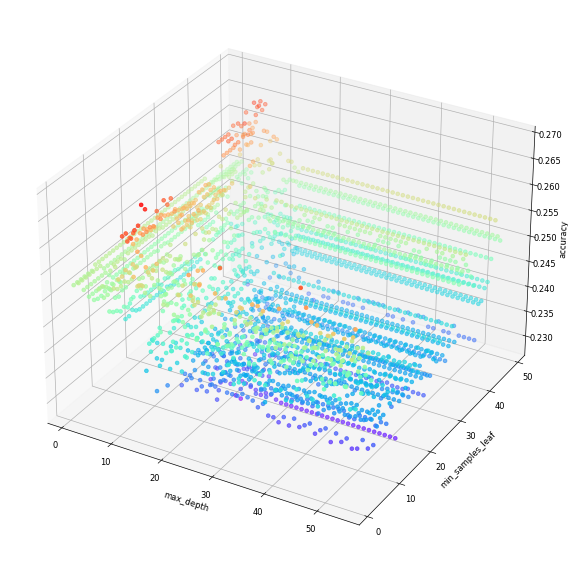

In [180]:
data_dtc = pd.read_csv("./debug/dec_tree_params_2.csv", encoding='gbk')
data = data_dtc.values

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x = data[:, 1]
y = data[:, 2]
z = data[:, 3]
plt.figure(dpi=60,figsize=(28, 12))
ax = plt.axes(projection = '3d')
ax.set_xlabel('max_depth')
ax.set_ylabel('min_samples_leaf')
ax.set_zlabel('accuracy')
ax.scatter(data[:, 1], data[:, 2], data[:, 3], c=data[:, 3], cmap="rainbow")

# ax.scatter(0, y, z, zdir='z', c='green', s=z*28 )    # 投影在 yz 平面
# ax.scatter(x, 0, z, zdir='z', c='gray', s=z*28 )    # 投影在 xz 平面
# ax.scatter(x, y, 0, zdir='z', c='cyan', s=z*28 )    # 投影在 xy 平面


In [181]:
# parameters = {
#     "criterion": "gini",    # 选择特征的标准，分为 "gini" 和 "entropy"
#     "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
#     "max_depth": 14,
#     "min_samples_split": 2,    # 叶子最小样本数
#     "min_samples_leaf": 4,     # 划分最小样本数
#     "max_leaf_nodes": 10000,    # 最大叶节点个数
#     "min_impurity_decrease": 0.0, # 最小划分不纯度减少量
#     "if_silent": 1
# }

In [182]:
# from Methods import RegTree as M_RT
# # 回归树模型

# m, n = y_train.shape 
# y_t = np.zeros((m, n))
# model_regtree = M_RT.RegressionTree(X_train, y_train, y_t)
# default_parameters = {
#     "lamda": 2,             # Hyperparameters
#     "gamma": 1e-6,          # Hyperparameters
#     "gain_delta": 0,        # The minimum gain
#     "max_depth": 3,
#     "max_leaves": 100,
#     "max_nodes": 1000,
#     "min_samples": 10,      # Minimum number of samples on a leaf
#     "min_feature_dif": 5,   # The minimum number of different value for current feature
#     "if_silent": 0
# }
# model_regtree.fit(default_parameters)
# pre = model_regtree.predict(X_test)

# acc = Accuracy(pre, Y_test)
# print("回归树模型分类准确度为 {}".format(acc))


SVM (01) 模型分类准确度为 0.525
SVM (02) 模型分类准确度为 0.5066079295154184
SVM (03) 模型分类准确度为 0.518796992481203
SVM (12) 模型分类准确度为 0.5171385991058122
SVM (13) 模型分类准确度为 0.5053435114503817
SVM (23) 模型分类准确度为 0.5121951219512195
SVM 模型分类准确度为 0.2649700598802395


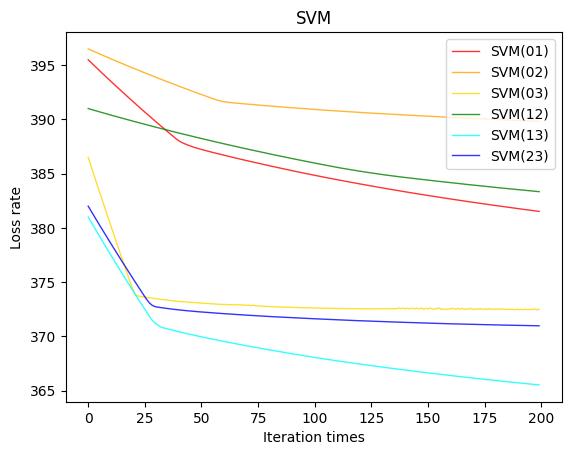

In [183]:
from Methods import SVM as M_SVM
# 支持向量机模型

def show(times, loss, color = '#4169E1', start=0, end=2000, title = ""):
    x_axis_data = list(range(times + 1))[start:end]
    y_axis_data = loss[start:end]
    plt.title(title)
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 1], rate=0.7)
model_SVM_01 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_01.fit(max_times=200, ifsilent=True)
pre_01 = model_SVM_01.predict(X_test)
acc_01 = Accuracy(pre_01, y_test)
print("SVM (01) 模型分类准确度为 {}".format(acc_01))
show(times, loss, color='RED')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 2], rate=0.7)
model_SVM_02 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_02.fit(max_times=200, ifsilent=True)
pre_02 = model_SVM_02.predict(X_test)
acc_02 = Accuracy(pre_02, y_test)
print("SVM (02) 模型分类准确度为 {}".format(acc_02))
show(times, loss, color='ORANGE')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 3], rate=0.7)
model_SVM_03 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_03.fit(max_times=200, ifsilent=True)
pre_03 = model_SVM_03.predict(X_test)
acc_03 = Accuracy(pre_03, y_test)
print("SVM (03) 模型分类准确度为 {}".format(acc_03))
show(times, loss, color='GOLD')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 2], rate=0.7)
model_SVM_12 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_12.fit(max_times=200, ifsilent=True)
pre_12 = model_SVM_12.predict(X_test)
acc_12 = Accuracy(pre_12, y_test)
print("SVM (12) 模型分类准确度为 {}".format(acc_12))
show(times, loss, color='GREEN')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 3], rate=0.7)
model_SVM_13 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_13.fit(max_times=200, ifsilent=True)
pre_13 = model_SVM_13.predict(X_test)
acc_13 = Accuracy(pre_13, y_test)
print("SVM (13) 模型分类准确度为 {}".format(acc_13))
show(times, loss, color='CYAN')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [2, 3], rate=0.7)
model_SVM_23 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_23.fit(max_times=200, ifsilent=True)
pre_23 = model_SVM_23.predict(X_test)
acc_23 = Accuracy(pre_23, y_test)
print("SVM (23) 模型分类准确度为 {}".format(acc_23))
show(times, loss, title="SVM", color='BLUE')

plt.legend(['SVM(01)', 'SVM(02)', 'SVM(03)', 'SVM(12)', 'SVM(13)', 'SVM(23)'], loc='upper right')
plt.xlabel('Iteration times')
plt.ylabel('Loss rate')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
pre_01 = model_SVM_01.predict(X_test)
pre_02 = model_SVM_02.predict(X_test)
pre_03 = model_SVM_03.predict(X_test)
pre_12 = model_SVM_12.predict(X_test)
pre_13 = model_SVM_13.predict(X_test)
pre_23 = model_SVM_23.predict(X_test)

m, _ = X_test.shape
pre_svm = np.zeros((m, 1))

for i in range(0, m):
    vote = [0, 0, 0, 0]
    vote[int(pre_01[i, 0])] += 1
    vote[int(pre_02[i, 0])] += 1
    vote[int(pre_03[i, 0])] += 1
    vote[int(pre_12[i, 0])] += 1
    vote[int(pre_13[i, 0])] += 1
    vote[int(pre_23[i, 0])] += 1
    pre_svm[i, 0] = vote.index(max(vote))
    

acc_svm = Accuracy(pre_svm, y_test)
print("SVM 模型分类准确度为 {}".format(acc_svm))

In [193]:
# 与 SKLearn 比较
from sklearn import svm 

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 1], rate=0.7)
model_SVM_01 = svm.SVC(kernel='linear')
model_SVM_01.fit(X_train, y_train.flatten())
pre_01 = model_SVM_01.predict(X_test).reshape(-1, 1)
acc_01 = Accuracy(pre_01, y_test)
print("SVM (01) 模型分类准确度为 {}".format(acc_01))

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 2], rate=0.7)
model_SVM_02 = svm.SVC(kernel='linear')
model_SVM_02 .fit(X_train, y_train.flatten())
pre_02 = model_SVM_02.predict(X_test).reshape(-1, 1)
acc_02 = Accuracy(pre_02, y_test)
print("SVM (02) 模型分类准确度为 {}".format(acc_02))

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 3], rate=0.7)
model_SVM_03 = svm.SVC(kernel='linear')
model_SVM_03.fit(X_train, y_train.flatten())
pre_03 = model_SVM_03.predict(X_test).reshape(-1, 1)
acc_03 = Accuracy(pre_03, y_test)
print("SVM (03) 模型分类准确度为 {}".format(acc_03))

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 2], rate=0.7)
model_SVM_12 = svm.SVC(kernel='linear')
model_SVM_12.fit(X_train, y_train.flatten())
pre_12 = model_SVM_12.predict(X_test).reshape(-1, 1)
acc_12 = Accuracy(pre_12, y_test)
print("SVM (12) 模型分类准确度为 {}".format(acc_12))

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 3], rate=0.7)
model_SVM_13 = svm.SVC(kernel='linear')
model_SVM_13.fit(X_train, y_train.flatten())
pre_13 = model_SVM_13.predict(X_test).reshape(-1, 1)
acc_13 = Accuracy(pre_13, y_test)
print("SVM (13) 模型分类准确度为 {}".format(acc_13))

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [2, 3], rate=0.7)
model_SVM_23 = svm.SVC(kernel='linear')
model_SVM_23.fit(X_train, y_train.flatten())
pre_23 = model_SVM_23.predict(X_test).reshape(-1, 1)
acc_23 = Accuracy(pre_23, y_test)
print("SVM (23) 模型分类准确度为 {}".format(acc_23))



X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
pre_01 = model_SVM_01.predict(X_test).reshape(-1, 1)
pre_02 = model_SVM_02.predict(X_test).reshape(-1, 1)
pre_03 = model_SVM_03.predict(X_test).reshape(-1, 1)
pre_12 = model_SVM_12.predict(X_test).reshape(-1, 1)
pre_13 = model_SVM_13.predict(X_test).reshape(-1, 1)
pre_23 = model_SVM_23.predict(X_test).reshape(-1, 1)


m, _ = X_test.shape
pre_svm = np.zeros((m, 1))

for i in range(0, m):
    vote = [0, 0, 0, 0]
    vote[int(pre_01[i, 0])] += 1
    vote[int(pre_02[i, 0])] += 1
    vote[int(pre_03[i, 0])] += 1
    vote[int(pre_12[i, 0])] += 1
    vote[int(pre_13[i, 0])] += 1
    vote[int(pre_23[i, 0])] += 1
    pre_svm[i, 0] = vote.index(max(vote))
    

acc_svm = Accuracy(pre_svm, y_test)
print("SVM 模型分类准确度为 {}".format(acc_svm))

SVM (01) 模型分类准确度为 0.5191176470588235
SVM (02) 模型分类准确度为 0.5066079295154184
SVM (03) 模型分类准确度为 0.5218045112781955
SVM (12) 模型分类准确度为 0.5305514157973175
SVM (13) 模型分类准确度为 0.4961832061068703
SVM (23) 模型分类准确度为 0.5167682926829269
SVM 模型分类准确度为 0.2597305389221557


In [122]:
from Methods import NeuralNet as M_NN
# 神经网络模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

parameters = {
    "hidden_layer_sizes": (20, 20, 20, 20, 20,),
    "activation": 'relu', # 激活函数, ‘identity’，‘logistic’，‘tanh’，‘relu’
    "alpha": 0.0001, # 可选，默认为0.0001。L2惩罚（正则化项）参数。
    "max_iter": 200, # 默认值200。最大迭代次数。solver迭代直到收敛（由’tol’确定）或这个迭代次数。对于随机解算器（‘sgd’，‘adam’），请注意，这决定了时期的数量（每个数据点的使用次数），而不是梯度步数。
    "tol": 1e-3, # 默认1e-4 优化的容忍度，容差优化。当n_iter_no_change连续迭代的损失或分数没有提高至少tol时，除非将learning_rate设置为’adaptive’，否则认为会达到收敛并且训练停止。
    "if_silent": False, 
    "early_stopping": True, # 当验证评分没有改善时，是否使用提前停止来终止培训。如果设置为true，它将自动留出10％的训练数据作为验证，并在验证得分没有改善至少为n_iter_no_change连续时期的tol时终止训练。仅在solver ='sgd’或’adam’时有效
    "validation_fraction": 0.05, # 将训练数据的比例留作早期停止的验证集。必须介于0和1之间。仅在early_stopping为True时使用
}

model_NN = M_NN.NeuralNetwork(X_train, y_train)
model_NN.fit(parameters)
pre = model_liner.predict(X_test)
print(pre)

acc_1 = Accuracy(pre, y_test)
print("神经网络模型分类准确度为 {}".format(acc_1))

Iteration 1, loss = 1.41750360
Validation score: 0.302564
Iteration 2, loss = 1.39592124
Validation score: 0.241026
Iteration 3, loss = 1.38925846
Validation score: 0.256410
Iteration 4, loss = 1.38655348
Validation score: 0.200000
Iteration 5, loss = 1.38611615
Validation score: 0.246154
Iteration 6, loss = 1.38627737
Validation score: 0.230769
Iteration 7, loss = 1.38575059
Validation score: 0.220513
Iteration 8, loss = 1.38571551
Validation score: 0.225641
Iteration 9, loss = 1.38573383
Validation score: 0.235897
Iteration 10, loss = 1.38544366
Validation score: 0.230769
Iteration 11, loss = 1.38514222
Validation score: 0.230769
Iteration 12, loss = 1.38495964
Validation score: 0.251282
Validation score did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
[[0.61422662]
 [1.65168916]
 [1.4308291 ]
 ...
 [1.84716499]
 [1.48184984]
 [1.63018864]]
神经网络模型分类准确度为 0.2375096079938509


d:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

def deep_model(feature_dim,label_dim):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(20, activation='relu', input_dim=feature_dim))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_deep(X_train,y_train,X_test,y_test):
    feature_dim = 12
    label_dim = 1
    model = deep_model(feature_dim,label_dim)
    model.summary()
    model.fit(X_train,y_train,batch_size=16, epochs=15,validation_data=(X_test,y_test))
    
train_deep(X_train,y_train,X_test,y_test)

create model. feature_dim =12, label_dim =1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                260       
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total para

In [124]:
from Methods import XGBoost as M_XGB
# XGBoost 模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

parameters = {
    "learning_rate": 0.3,       # 如同学习率
    "min_child_weight": 1, 
    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
    #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    "max_depth": 10,             # 构建树的深度，越大越容易过拟合
    "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
    "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
    "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
    "colsample_bytree": 1,      # 生成树时进行的列采样 
    "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    "reg_alpha": 0,             # L1 正则项参数
    "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
    "num_class": 4,             # 类别数
    "n_estimators": 20,         # 树的个数
    "seed": 2000,                # 随机种子     
    "if_silent": 1,
}

model_XGB = M_XGB.XGBoost(X_train, y_train)
model_XGB.fit(parameters)
# model_XGB.save("./model/Model_XGBoost_0.28")
# model_XGB= pk.load(open("./model/Model_XGBoost_0.28", "rb")) 

pre = model_XGB.predict(X_test)
pre = np.array(pre).reshape(-1, 1)

acc_xgb = Accuracy(pre, y_test)
print("XGBoost 模型分类准确度为 {}".format(acc_xgb))


XGBoost 模型分类准确度为 0.28516525749423516


In [125]:
from Methods import XGBoost as M_XGB
# XGBoost 模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)

parameters = {
    "learning_rate": 0.3,       # 如同学习率
    "min_child_weight": 1, 
    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
    #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    "max_depth": 16,             # 构建树的深度，越大越容易过拟合
    "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
    "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
    "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
    "colsample_bytree": 1,      # 生成树时进行的列采样 
    "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    "reg_alpha": 0,             # L1 正则项参数
    "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
    "num_class": 4,             # 类别数
    "n_estimators": 20,         # 树的个数
    "seed": 2000,                # 随机种子     
    "if_silent": 1,
}

def my_sort(t1):
    return t1[2]

acc_list = []
N=1
for depth in range(1, 50):
    for t in range(10, 100, 5):
    
        parameters['max_depth'] = depth
        parameters['n_estimators'] = t 
        acc_sum = 0
        
        for times in range (1, N+1):
        
            X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
            model_XGB = M_XGB.XGBoost(X_train, y_train)
            model_XGB.fit(parameters)

            pre = model_XGB.predict(X_test)
            pre = np.array(pre).reshape(-1, 1)
            acc_sum += Accuracy(pre, y_test)
            
        acc_list.append((depth, t, acc_sum/N))
        
        acc_list.sort(key = my_sort)
        test = pd.DataFrame(data=acc_list)
        test.to_csv("./debug/xgb_params_1.csv",encoding='gbk')
    



KeyboardInterrupt: 

In [ ]:
# parameters = {
#     "learning_rate": 0.3,       # 如同学习率
#     "min_child_weight": 1, 
#     # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#     #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#     # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
#     "max_depth": 9,             # 构建树的深度，越大越容易过拟合
#     "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
#     "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
#     "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
#     "colsample_bytree": 1,      # 生成树时进行的列采样 
#     "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#     "reg_alpha": 0,             # L1 正则项参数
#     "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
#     "num_class": 4,             # 类别数
#     "n_estimators": 90,         # 树的个数
#     "seed": 2000,                # 随机种子     
#     "if_silent": 1,
# }
